<a href="https://colab.research.google.com/github/jcuesta123/TFM-RL/blob/main/helicopter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First approach of the code of helicopter

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


In [5]:
#helicopter parameters
g = 10
m_h = 1
deltaT = 0.1

max_action_space = np.array([2*m_h*g, math.pi/4])
min_action_space = np.array([0, -math.pi/4])
observation_space = np.array([0., 0., 0., 0., 1, 0])

print(max_action_space, ' -->  Max Traction (N) and max angle (rad)')
print(min_action_space, ' -->  Min Traction (N) and min angle (rad)')
print(observation_space, ' -->  x, y, v_x, v_y, floor_contact, lateral_contact')

[20.          0.78539816]  -->  Max Traction (N) and max angle (rad)
[ 0.         -0.78539816]  -->  Min Traction (N) and min angle (rad)
[0. 0. 0. 0. 1. 0.]  -->  x, y, v_x, v_y, floor_contact, lateral_contact


In [6]:
# ACTION
#to make it more realistic, it only can vary its controls  smoothly, through some discrete levels, so that's the reasonof (previous) command input
def select_action(state, command):

  epsilon = 0.5
  action_number = 0
  command = np.array(command)

  result = np.random.uniform()
  if result < epsilon:
    action_number = random.randint(1, 5)
  else:
    #qs = main_nn(state).cpu().data.numpy()
    #action_number = np.argmax(qs)
    action_number = random.randint(1, 5)  #action_number = np.argmax(main_nn(torch.tensor(state).unsqueeze(0)).cpu().data.numpy()) #########OJOOOOOOOOOOO

  if action_number == 1:
    new_command = command
  elif action_number == 2:
    new_command = command + max_action_space/10 * np.array([1, 0])
  elif action_number == 3:
    new_command = command + max_action_space/10 * np.array([-1, 0])
  elif action_number == 4:
    new_command = command + max_action_space/10 * np.array([0, 1])
  else: # action_number == 5:
    new_command = command + max_action_space/10 * np.array([0, -1])

  if new_command[0] > 2*m_h*g or new_command[0] < 0:
    new_command[0] = command[0]
  if new_command[1] > math.pi/4 or new_command[1] < -math.pi/4:
    new_command[1] = command[1]

  return new_command

In [ ]:
print(torch.from_numpy(np.expand_dims(state, axis=0)).to(device))

tensor([[-0.1386,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000]],
       dtype=torch.float64)


In [7]:
max_action_space/10 + max_action_space/10 * np.array([0, 0])

array([2.        , 0.07853982])

In [10]:
#environment, based on pyhsics, num. computation and conditionals
def environment(state, command):

  crash = False
  #Situation
  #On ground - in flight
  if state[1] < 0.01:
    state[4] = 1.
    if state[3] < -3:
      crash = True
  else:
    state[4] = 0.

  #Mechanics
  #Forces
  a_x = command[0]*math.sin(command[1])/m_h
  a_y = command[0]*math.cos(command[1])/m_h - g

  #Velocities
  state[2] = state[2] + deltaT*a_x
  state[3] = state[3] + deltaT*a_y

  #Positions
  state[0] = state[0] + deltaT*state[2]
  state[1] = state[1] + deltaT*state[3]

  if state[4] == 1. and command[0]*math.cos(command[1]) < m_h*g:
    a_x = 0.      #considered friction equals to traction x cos
    a_y = 0.
    state[1] = 0.
    state[2] = 0.
    state[3] = 0.

  reward = reward_function()

  return state, reward, crash

def reward_function():

  reward = 51 - math.sqrt((dest[0]-state[0])**2+(dest[1]-state[1])**2)

  return reward

In [12]:
# MAIN LOOP

dest = np.array([50, 10])
total_reward = 0
state = np.array([0., 0., 0., 0., 1., 0.])
command = np.array([0, 0])
matrix_state = observation_space

for i in range(1000):  #if deltaT = 0.1 sec -> simulation represents up to 100 sec

  state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)

  action = select_action(state_in, command)            # STEP 1 -> choose ACTION
  command = action                                  # recording command for next action

  state, reward, crash = environment(state, action)       # STEP 2 -> process ENVIRONMENT
  matrix_state = np.vstack([matrix_state, state])

  total_reward += reward                            # add or substract reward to total

  if crash == True:
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('Helicopter crashed at iteration ',i)
    break

  if dest[0]-1 < state[0] < dest[0]+1 and dest[1]-1 < state[1] < dest[1]+1:  #OJO implementarlo bien
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('Helicopter reached destination at iteration ',i)
    break


  if i % 10 == 0:
    print('i=', i, '   x, y= ', np.round(state[0],2), np.round(state[1],2), '   Vx, Vy= ', np.round(state[2],2), np.round(state[3],2),';    on ground: ', \
          bool(state[4]), ';F=', np.round(command[0]*math.cos(command[1])/m_h - g,2), np.round(total_reward,1))



i= 0    x, y=  0.0 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -10.0 0.0
i= 10    x, y=  0.02 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -6.11 0.1
i= 20    x, y=  0.12 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -6.01 1.1
i= 30    x, y=  0.25 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -4.07 3.0
i= 40    x, y=  0.33 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -6.05 5.9
i= 50    x, y=  0.35 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -10.0 9.4
i= 60    x, y=  0.35 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -10.0 12.9
i= 70    x, y=  0.39 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -10.0 16.6
i= 80    x, y=  0.54 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -5.15 21.0
i= 90    x, y=  0.98 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -3.18 28.8
i= 100    x, y=  1.24 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -4.65 40.0
i= 110    x, y=  1.61 0.0    Vx, Vy=  0.0 0.0 ;    on ground:  True ;F= -4.88 54.3
i= 120    x, y=  1.99 

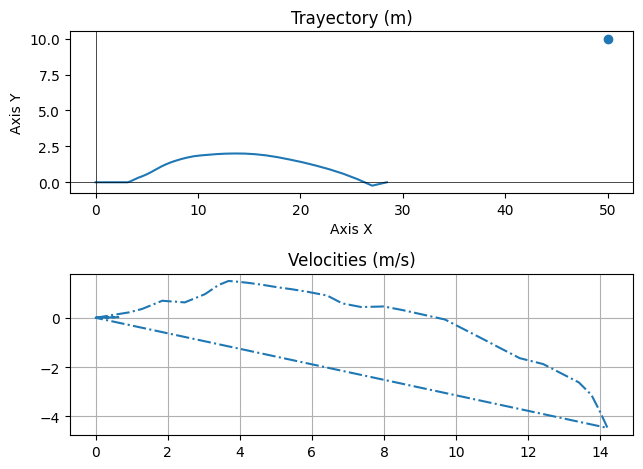

In [13]:
#PRINT TRAJECTORY

x = matrix_state[:, 0]
y = matrix_state[:, 1]

v_x = matrix_state[:, 2]
v_y = matrix_state[:, 3]


plt.subplot(2, 1, 1)  # 2 filas, 1 columna, primera posición
plt.plot(x, y)  # 'r--' indica línea roja discontinua
plt.scatter(dest[0],dest[1])
plt.title('Trayectory (m)')
plt.xlabel('Axis X')
plt.ylabel('Axis Y')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.subplot(2, 1, 2)  # 2 filas, 1 columna, primera posición
plt.plot(v_x, v_y,'-.')  # 'r--' indica línea roja discontinua
plt.title('Velocities (m/s)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
num_actions = 5 # no changes, less/more traction, left/right steer
num_features = 6  # x,y,vx,vy,floor/lateral contact

#Usar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

main_nn = DQN(num_features, num_actions).to(device)   #para meter GPU
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

cpu
